In [1]:
# ==========================
# Основные библиотеки
# ==========================
import numpy as np
import pandas as pd
import warnings

# ==========================
# Визуализация
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ==========================
# Предобработка данных
# ==========================
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler

# ==========================
# Модели и обучение
# ==========================
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,
    StackingRegressor, AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# ==========================
# Метрики
# ==========================
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
)

# ==========================
# Библиотеки для бустинга
# ==========================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

# ==========================
# Статистика
# ==========================
from scipy.stats import f_oneway


In [2]:
df = pd.read_csv("df.csv")
df_bin = pd.read_csv("df_bin.csv")
df_cut = pd.read_csv("df_cut.csv")
df_cut_bin = pd.read_csv("df_cut_bin.csv")

In [3]:
print("Размерности датафреймов:")
print(f"df: {df.shape[0]} строк, {df.shape[1]} признаков")
print(f"df_bin: {df_bin.shape[0]} строк, {df_bin.shape[1]} признаков")
print(f"df_cut: {df_cut.shape[0]} строк, {df_cut.shape[1]} признаков")
print(f"df_cut_bin: {df_cut_bin.shape[0]} строк, {df_cut_bin.shape[1]} признаков")

Размерности датафреймов:
df: 1001 строк, 233 признаков
df_bin: 1001 строк, 233 признаков
df_cut: 1001 строк, 161 признаков
df_cut_bin: 1001 строк, 98 признаков


Сравниваем разные модели

In [5]:
!pip install catboost

In [6]:
df = df.drop(columns=['IC50, mM'])
df_bin = df_bin.drop(columns=['IC50, mM'])
df_cut = df_cut.drop(columns=['IC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['IC50, mM'])
#df = df.drop(columns=['log_IC50'])
#df_bin = df_bin.drop(columns=['log_IC50'])
#df_cut = df_cut.drop(columns=['log_IC50'])
#df_cut_bin = df_cut_bin.drop(columns=['log_IC50'])


df = df.drop(columns=['SI'])
df_bin = df_bin.drop(columns=['SI'])
df_cut = df_cut.drop(columns=['SI'])
df_cut_bin = df_cut_bin.drop(columns=['SI'])
df = df.drop(columns=['log_SI'])
df_bin = df_bin.drop(columns=['log_SI'])
df_cut = df_cut.drop(columns=['log_SI'])
df_cut_bin = df_cut_bin.drop(columns=['log_SI'])
df = df.drop(columns=['CC50, mM'])
df_bin = df_bin.drop(columns=['CC50, mM'])
df_cut = df_cut.drop(columns=['CC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['CC50, mM'])
df = df.drop(columns=['log_CC50'])
df_bin = df_bin.drop(columns=['log_CC50'])
df_cut = df_cut.drop(columns=['log_CC50'])
df_cut_bin = df_cut_bin.drop(columns=['log_CC50'])

In [7]:
if 'IC50, mM' in df.columns:
    print("Колонка 'IC50, mM' есть в DataFrame.")
else:
    print("Колонки 'IC50, mM' нет в DataFrame.")

Колонки 'IC50, mM' нет в DataFrame.


=== Evaluation on df ===


Cross-validation (228 features): 100%|██████████| 9/9 [07:43<00:00, 51.52s/it] 


=== Evaluation on df_cut ===


Cross-validation (156 features): 100%|██████████| 9/9 [04:18<00:00, 28.75s/it]


=== Evaluation on df_bin ===


Cross-validation (228 features): 100%|██████████| 9/9 [07:08<00:00, 47.65s/it] 


=== Evaluation on df_cut_bin ===


Cross-validation (93 features): 100%|██████████| 9/9 [03:50<00:00, 25.65s/it]


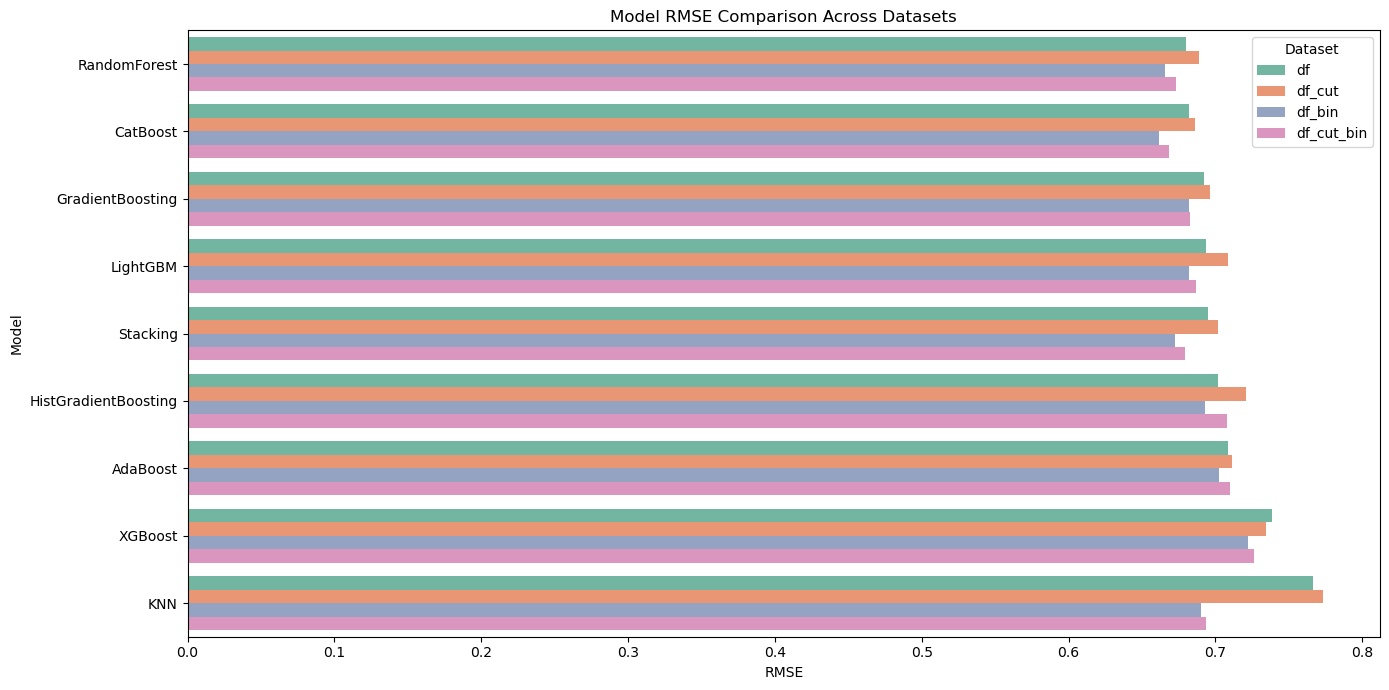

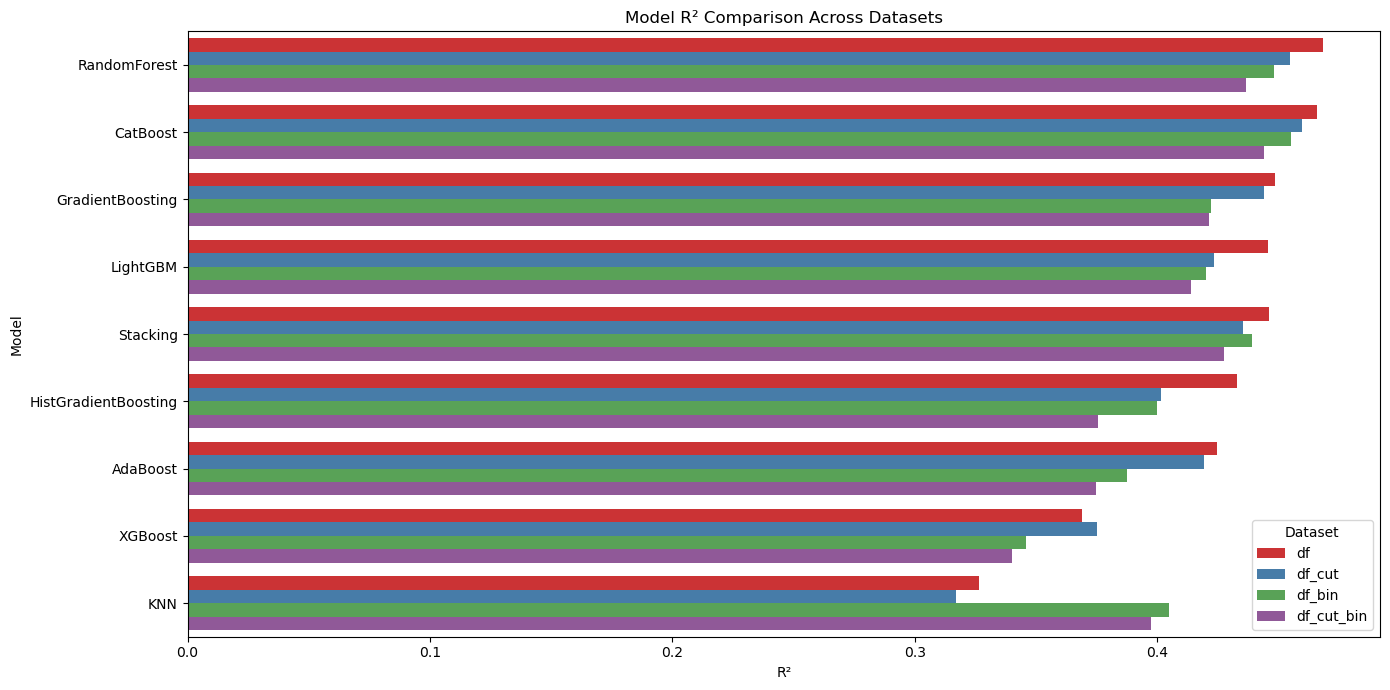


Model metrics comparison:
                         MAE                               RMSE          \
Dataset                   df  df_bin  df_cut df_cut_bin      df  df_bin   
Model                                                                     
AdaBoost              0.5885  0.5856  0.5855     0.5930  0.7085  0.7028   
CatBoost              0.5342  0.5228  0.5400     0.5277  0.6819  0.6619   
GradientBoosting      0.5442  0.5411  0.5509     0.5451  0.6925  0.6819   
HistGradientBoosting  0.5311  0.5258  0.5505     0.5424  0.7018  0.6932   
KNN                   0.5916  0.5400  0.5963     0.5405  0.7664  0.6902   
LightGBM              0.5351  0.5292  0.5465     0.5346  0.6938  0.6823   
RandomForest          0.5283  0.5206  0.5330     0.5247  0.6797  0.6657   
Stacking              0.5455  0.5334  0.5506     0.5428  0.6949  0.6722   
XGBoost               0.5602  0.5485  0.5548     0.5515  0.7383  0.7225   

                                             R²                         

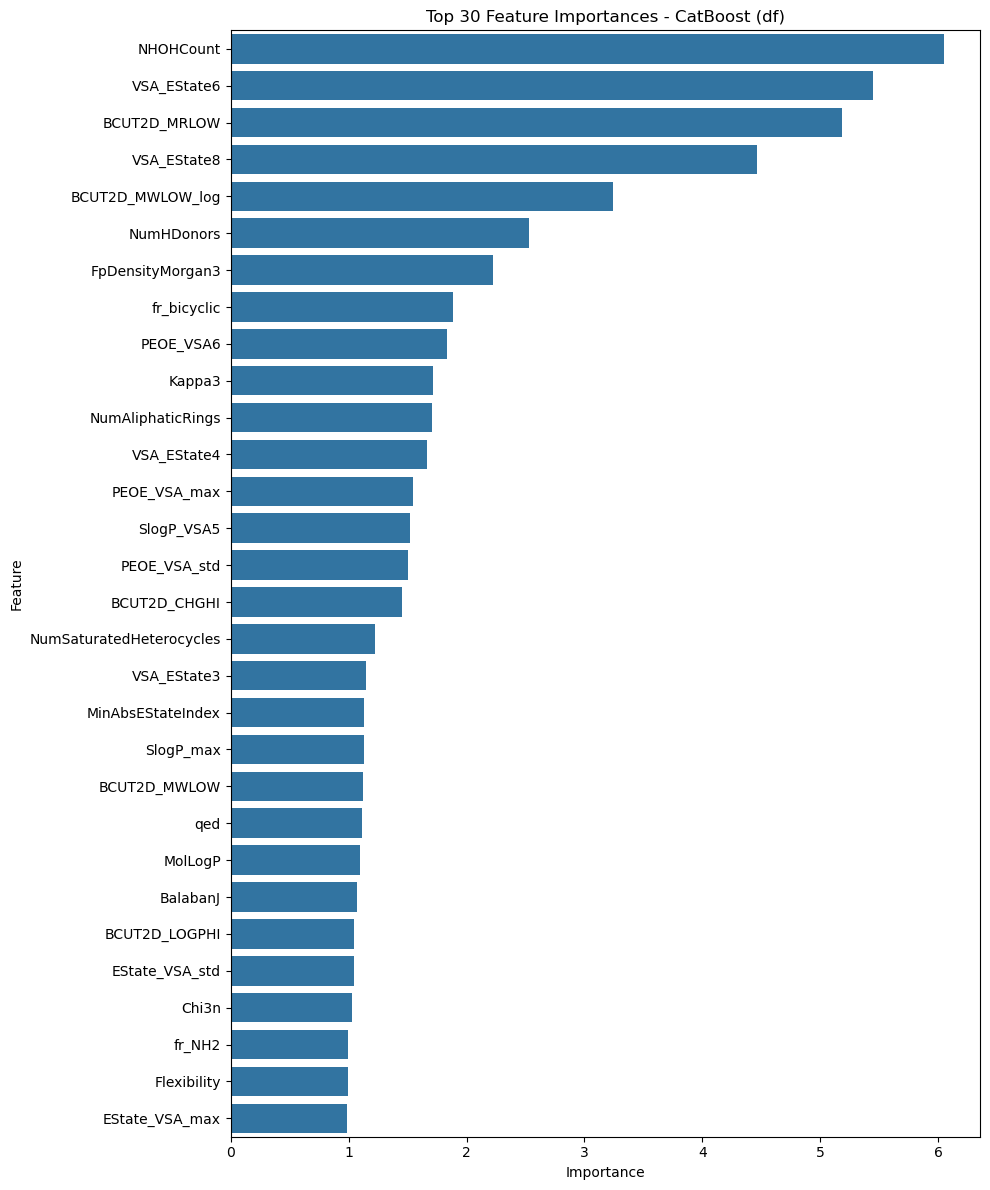

Best model on df by RMSE: RandomForest


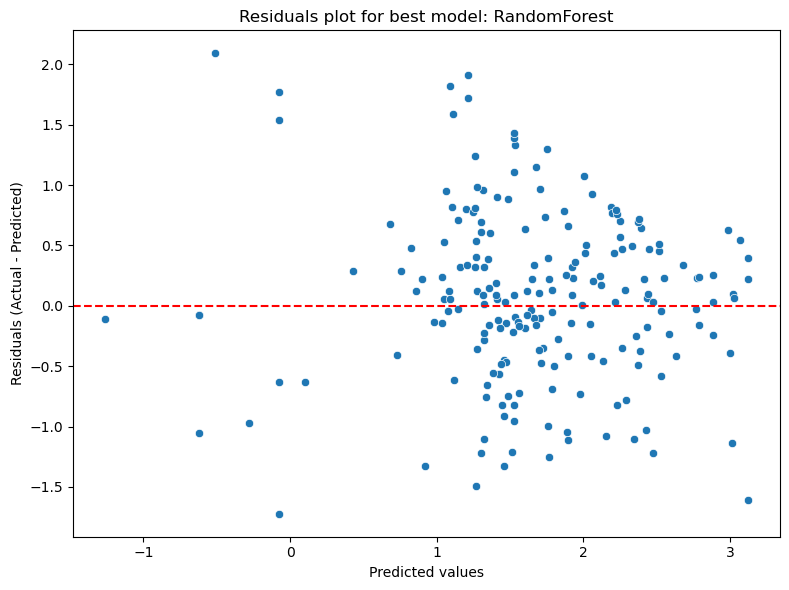

In [9]:
warnings.filterwarnings("ignore")

# Очистка имён колонок и замена inf на nan
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, verbosity=0)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42)),
]

final_estimator = LinearRegression()
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

models = {
    "KNN": KNeighborsRegressor(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42, min_gain_to_split=0, max_depth=6, num_leaves=31, verbose=-1),
    "CatBoost": CatBoostRegressor(
        verbose=0,
        random_state=42,
        bagging_temperature=0.13,
        depth=4,
        iterations=626,
        l2_leaf_reg=4.2,
        learning_rate=0.04
    ),

    "Stacking": stacking_model
}

def evaluate_models(df_input, y_col='log_IC50'):
    df_eval = df_input.copy()
    df_eval = df_eval.drop(columns=['Unnamed_0'], errors='ignore')

    X = df_eval.drop(columns=[y_col])
    y = df_eval[y_col]

    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    imputer = SimpleImputer(strategy='most_frequent')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        try:
            cv_results = cross_validate(
                model, X_scaled, y,
                cv=kf,
                scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_median_absolute_error'],
                return_train_score=False,
                n_jobs=-1
            )

            mae_mean = -np.mean(cv_results['test_neg_mean_absolute_error'])
            mse_mean = -np.mean(cv_results['test_neg_mean_squared_error'])
            rmse_mean = np.sqrt(mse_mean)
            r2_mean = np.mean(cv_results['test_r2'])
            medae_mean = -np.mean(cv_results['test_neg_median_absolute_error'])

            results.append({
                "Model": name,
                "MAE": mae_mean,
                "MSE": mse_mean,
                "RMSE": rmse_mean,
                "MedAE": medae_mean,
                "R²": r2_mean
            })
        except Exception as e:
            print(f"Error in model {name}: {e}")
    return pd.DataFrame(results).sort_values(by="RMSE"), X_scaled, y, imputer, scaler

# Оценка всех датасетов и сбор результатов
print("=== Evaluation on df ===")
results_df, X_df_scaled, y_df, imputer_df, scaler_df = evaluate_models(df)
results_df['Dataset'] = 'df'

print("=== Evaluation on df_cut ===")
results_df_cut, X_cut_scaled, y_cut, imputer_cut, scaler_cut = evaluate_models(df_cut)
results_df_cut['Dataset'] = 'df_cut'

print("=== Evaluation on df_bin ===")
results_df_bin, X_bin_scaled, y_bin, imputer_bin, scaler_bin = evaluate_models(df_bin)
results_df_bin['Dataset'] = 'df_bin'

print("=== Evaluation on df_cut_bin ===")
results_df_cut_bin, X_cut_bin_scaled, y_cut_bin, imputer_cut_bin, scaler_cut_bin = evaluate_models(df_cut_bin)
results_df_cut_bin['Dataset'] = 'df_cut_bin'

comparison_df = pd.concat([results_df, results_df_cut, results_df_bin, results_df_cut_bin], ignore_index=True)

# Визуализация RMSE
plt.figure(figsize=(14, 7))
sns.barplot(data=comparison_df, x='RMSE', y='Model', hue='Dataset', palette='Set2')
plt.title("Model RMSE Comparison Across Datasets")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

# Визуализация R²
plt.figure(figsize=(14, 7))
sns.barplot(data=comparison_df, x='R²', y='Model', hue='Dataset', palette='Set1')
plt.title("Model R² Comparison Across Datasets")
plt.xlabel("R²")
plt.ylabel("Model")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

print("\nModel metrics comparison:")
print(comparison_df.pivot_table(index="Model", columns="Dataset", values=["RMSE", "R²", "MAE"]).round(4))

# --- Визуализация важности признаков для CatBoost на df (пример) ---
cat_model = models['CatBoost']
cat_model.fit(X_df_scaled, y_df)

# Получение важности признаков
feature_importances = cat_model.get_feature_importance(Pool(X_df_scaled, label=y_df))
feat_imp_df = pd.DataFrame({
    'Feature': X_df_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Top 30 Feature Importances - CatBoost (df)")
plt.tight_layout()
plt.show()

# --- График остатков для лучшей модели на df ---
# Определим лучшую модель по RMSE на df
best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
print(f"Best model on df by RMSE: {best_model_name}")

best_model = models[best_model_name]

# Для графика остатков нужна обучающая и тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(X_df_scaled, y_df, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residuals plot for best model: {best_model_name}')
plt.tight_layout()
plt.show()

# --- Сохраняем результаты в Excel и PDF ---
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('regression_evaluation_report_IC50.pdf') as pdf:
    # RMSE Plot
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_df, x='RMSE', y='Model', hue='Dataset', palette='Set2')
    plt.title("Model RMSE Comparison Across Datasets")
    plt.xlabel("RMSE")
    plt.ylabel("Model")
    plt.legend(title="Dataset")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # R² Plot
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_df, x='R²', y='Model', hue='Dataset', palette='Set1')
    plt.title("Model R² Comparison Across Datasets")
    plt.xlabel("R²")
    plt.ylabel("Model")
    plt.legend(title="Dataset")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Feature importance CatBoost
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
    plt.title("Top 20 Feature Importances - CatBoost (df)")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Residuals plot best model
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residuals plot for best model: {best_model_name}')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Табличное сравнение
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.axis('off')
    ax.axis('tight')

    table_data = comparison_df.pivot_table(
        index="Model",
        columns="Dataset",
        values=["RMSE", "R²", "MAE"]
    ).round(4)

    tbl = ax.table(
        cellText=table_data.values,
        colLabels=[f'{metric}_{ds}' for metric, ds in table_data.columns],
        rowLabels=table_data.index,
        loc='center',
        cellLoc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    ax.set_title("Model metrics comparison")
    pdf.savefig()
    plt.close()

with pd.ExcelWriter("regression_comparison_metrics_IC50.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="df", index=False)
    results_df_cut.to_excel(writer, sheet_name="df_cut", index=False)
    results_df_bin.to_excel(writer, sheet_name="df_bin", index=False)
    results_df_cut_bin.to_excel(writer, sheet_name="df_cut_bin", index=False)
    comparison_df.to_excel(writer, sheet_name="Comparison", index=False)


- двухэтапная настройка CatBoost на данных df: сначала RandomizedSearchCV для определения перспективной области параметров, затем GridSearchCV для её уточнения

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform
from catboost import CatBoostRegressor
from tqdm import tqdm

# --- 1. Данные и подготовка ---

X = df.drop(columns=['log_IC50'])
y = df['log_IC50']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# --- 2. Базовая модель ---
base_model = CatBoostRegressor(verbose=0, random_state=42)

# --- 3. Метрики ---
scoring = {
    'rmse': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# --- 4. RandomizedSearchCV ---
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.1),
    'iterations': randint(300, 800),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
}

print(" Запуск RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring=scoring,
    refit='r2',
    cv=3,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

with tqdm(total=1, desc="RandomizedSearchCV") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)

print(" Предварительно лучшие параметры (RandomizedSearchCV):")
print(random_search.best_params_)

# --- 5. GridSearchCV — тонкая настройка ---
best_params = random_search.best_params_
param_grid = {
    'depth': list(set([max(1, best_params['depth'] - 1), best_params['depth'], best_params['depth'] + 1])),
    'learning_rate': [round(best_params['learning_rate'] * r, 3) for r in [0.8, 1.0, 1.2]],
    'iterations': [best_params['iterations'] - 100, best_params['iterations'], best_params['iterations'] + 100],
    'l2_leaf_reg': [round(best_params['l2_leaf_reg'] * r, 1) for r in [0.8, 1.0, 1.2]],
    'bagging_temperature': [round(best_params['bagging_temperature'] * r, 2) for r in [0.8, 1.0, 1.2]]
}

for key, vals in param_grid.items():
    param_grid[key] = sorted(list(set([v for v in vals if v >= 0])))

print("\n Запуск GridSearchCV...")
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='r2',
    cv=3,
    n_jobs=-1,
    return_train_score=True
)

with tqdm(total=1, desc="GridSearchCV") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(1)

print(" Точно настроенные параметры (GridSearchCV):")
print(grid_search.best_params_)

# --- 6. Оценка на тесте ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))  # ← исправлено
r2_test = r2_score(y_test, y_pred)

print("\n Метрики на тестовой выборке:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²:   {r2_test:.4f}")
# --- 7. Сохранение результатов ---
results = {
    "best_params_random": random_search.best_params_,
    "best_params_grid": grid_search.best_params_,
    "rmse_test": rmse_test,
    "r2_test": r2_test
}

with open("IC_50_regression_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("\n Результаты сохранены в results.json")

# --- 8. График Actual vs Predicted ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('True log(IC50)')
plt.ylabel('Predicted log(IC50)')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.savefig("IC_50_regression_catboost_actual_vs_predicted.png")
plt.show()

# --- 9. Feature Importance ---
importances = best_model.get_feature_importance()
features = X.columns

plt.figure(figsize=(10, 30))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (CatBoost)")
plt.tight_layout()
plt.savefig("IC_50_regression_catboost_feature_importance.png")
plt.show()


 Запуск RandomizedSearchCV...


RandomizedSearchCV:   0%|          | 0/1 [01:22<?, ?it/s]


KeyboardInterrupt: 

In [14]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib

print("Сохраняю файлы в папку:", os.getcwd())

df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация средним значением
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# Кросс-валидация
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 6-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# Остатки
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50): Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.close()

# Важность признаков
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_imputed, y)

feature_importances = cat_model_final.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log(IC50): Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.close()

joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model_df_to SI_ckass.pkl')



Сохраняю файлы в папку: C:\Users\apex_\SF
Running 6-fold cross-validation...
Fold 1 R²: 0.4901
Fold 2 R²: 0.3535
Fold 3 R²: 0.4937
Fold 4 R²: 0.4530
Fold 5 R²: 0.4967
Fold 6 R²: 0.5543

Cross-validation results:
MAE: 0.5334 ± 0.0268
RMSE: 0.6779 ± 0.0304
R²: 0.4735 ± 0.0613

Test set performance:
MAE: 0.5510
MSE: 0.5059
RMSE: 0.7113
MedAE: 0.4103
R²: 0.4922


['regression_IC50_catboost_final_model_df_to SI_ckass.pkl']

In [76]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib

print("Сохраняю файлы в папку:", os.getcwd())

df_copy = df_cut_bin.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация средним значением
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# Кросс-валидация
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 6-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# Остатки
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50): Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.close()

# Важность признаков
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_imputed, y)

feature_importances = cat_model_final.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log(IC50): Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.close()

joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model_cut_bin_to SI_ckass.pkl')



Сохраняю файлы в папку: C:\Users\apex_\SF
Running 6-fold cross-validation...
Fold 1 R²: 0.4797
Fold 2 R²: 0.3664
Fold 3 R²: 0.4632
Fold 4 R²: 0.4083
Fold 5 R²: 0.4805
Fold 6 R²: 0.5329

Cross-validation results:
MAE: 0.5240 ± 0.0219
RMSE: 0.6634 ± 0.0254
R²: 0.4552 ± 0.0539

Test set performance:
MAE: 0.5449
MSE: 0.4774
RMSE: 0.6909
MedAE: 0.4195
R²: 0.4757


['regression_IC50_catboost_final_model_cut_bin_to SI_ckass.pkl']

In [28]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib

print("Сохраняю файлы в папку:", os.getcwd())

df_copy = df_bin.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация средним значением
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# Кросс-валидация
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 6-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Тестовая выборка
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# Остатки
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50): Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(IC50)_catboost_residuals_plot.png")
plt.close()

# Важность признаков
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_imputed, y)

feature_importances = cat_model_final.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log(IC50): Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.savefig("log(IC50)_catboost_feature_importance_top30.png")
plt.close()

joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model_bin.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model_bin.pkl'")
print("Графики сохранены в 'log(IC50)_catboost_residuals_plot.png' и 'log(IC50)_catboost_feature_importance_top30.png'")


Сохраняю файлы в папку: C:\Users\apex_\SF
Running 6-fold cross-validation...
Fold 1 R²: 0.4753
Fold 2 R²: 0.3588
Fold 3 R²: 0.4749
Fold 4 R²: 0.4258
Fold 5 R²: 0.4847
Fold 6 R²: 0.5359

Cross-validation results:
MAE: 0.5224 ± 0.0258
RMSE: 0.6609 ± 0.0257
R²: 0.4592 ± 0.0551

Test set performance:
MAE: 0.5398
MSE: 0.4668
RMSE: 0.6832
MedAE: 0.4103
R²: 0.4873
Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model_bin.pkl'
Графики сохранены в 'log(IC50)_catboost_residuals_plot.png' и 'log(IC50)_catboost_feature_importance_top30.png'


In [44]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib  # для сохранения модели

# Убедимся, что рабочая директория известна
print("Сохраняю файлы в папку:", os.getcwd())

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
#df_copy = df.copy()
df_copy = df_cut_bin.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# Разделяем X и y
X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация пропусков (most_frequent)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели CatBoost
catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# Кросс-валидация с KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Оценка производительности на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

# Метрики качества на тесте
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50) Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(IC50)_catboost_residuals_plot.png")
plt.close()

# Визуализация важности признаков (по всей выборке)
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_imputed, y)

feature_importances = cat_model_final.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log (IC50): Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.savefig("log(IC50)_catboost_feature_importance_top30.png")
plt.close()

# Сохранение финальной модели
joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model_cut_bin.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model.pkl'")
print("Графики сохранены в 'catboost_residuals_plot_ic50.png' и 'catboost_feature_importance_top30_ic50.png'")


Сохраняю файлы в папку: C:\Users\apex_\SF
Running 5-fold cross-validation...
Fold 1 R²: 0.4854
Fold 2 R²: 0.4855
Fold 3 R²: 0.3196
Fold 4 R²: 0.2885
Fold 5 R²: 0.4650
Fold 6 R²: 0.3330
Fold 7 R²: 0.4968
Fold 8 R²: 0.4331
Fold 9 R²: 0.5976
Fold 10 R²: 0.5347

Cross-validation results:
MAE: 0.5247 ± 0.0360
RMSE: 0.6636 ± 0.0344
R²: 0.4439 ± 0.0952

Test set performance:
MAE: 0.5449
MSE: 0.4774
RMSE: 0.6909
MedAE: 0.4195
R²: 0.4757
Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model.pkl'
Графики сохранены в 'catboost_residuals_plot_ic50.png' и 'catboost_feature_importance_top30_ic50.png'


In [15]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib  # для сохранения модели

# Убедимся, что рабочая директория известна
print("Сохраняю файлы в папку:", os.getcwd())

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
#df_copy = df.copy()
df_copy = df_cut.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# Разделяем X и y
X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация пропусков (most_frequent)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели CatBoost
catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# Кросс-валидация с KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 5-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Оценка производительности на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

# Метрики качества на тесте
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50) Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(IC50)_catboost_residuals_plot.png")
plt.close()

# Визуализация важности признаков (по всей выборке)
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_imputed, y)

feature_importances = cat_model_final.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log (IC50): Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.savefig("log(IC50)_catboost_feature_importance_top30.png")
plt.close()

# Сохранение финальной модели
joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model_to CC50_class.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model.pkl'")
print("Графики сохранены в 'catboost_residuals_plot_ic50.png' и 'catboost_feature_importance_top30_ic50.png'")


Сохраняю файлы в папку: C:\Users\apex_\SF
Running 5-fold cross-validation...
Fold 1 R²: 0.5324
Fold 2 R²: 0.4825
Fold 3 R²: 0.3013
Fold 4 R²: 0.3315
Fold 5 R²: 0.4873
Fold 6 R²: 0.3353
Fold 7 R²: 0.5693
Fold 8 R²: 0.4339
Fold 9 R²: 0.5947
Fold 10 R²: 0.5487

Cross-validation results:
MAE: 0.5328 ± 0.0400
RMSE: 0.6782 ± 0.0378
R²: 0.4617 ± 0.1012

Test set performance:
MAE: 0.5624
MSE: 0.5135
RMSE: 0.7166
MedAE: 0.4245
R²: 0.4845
Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model.pkl'
Графики сохранены в 'catboost_residuals_plot_ic50.png' и 'catboost_feature_importance_top30_ic50.png'


- изучим остатки на ключевых признаках:

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import joblib

# 1. Загрузка сохраненной модели
model = joblib.load('catboost_best_model_IC50.pkl')



# 3. Получение предсказаний и остатков
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# 4. Определение выбросов (образцов с наибольшими ошибками)
outlier_threshold = 2 * np.std(residuals)  # можно настроить порог
outliers_mask = np.abs(residuals) > outlier_threshold

print(f"Найдено {sum(outliers_mask)} выбросов (ошибка > {outlier_threshold:.2f})")

# 5. SHAP-анализ для выбросов
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[outliers_mask])

# 6. Визуализация
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, 
                 features=X_test[outliers_mask], 
                 feature_names=X_test.columns,
                 plot_type="bar",
                 show=False)
plt.title(f'SHAP Feature Importance for {sum(outliers_mask)} Outlier Predictions')
plt.tight_layout()
plt.show()

# Дополнительно: beeswarm plot для более детального анализа
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, 
                 features=X_test[outliers_mask], 
                 feature_names=X_test.columns,
                 plot_type="dot",
                 show=False)
plt.title(f'SHAP Values for Outlier Predictions')
plt.tight_layout()
plt.show()

In [29]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib  # для сохранения модели

# Убедимся, что рабочая директория известна
print("Сохраняю файлы в папку:", os.getcwd())

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# === Добавление признака log_CC50 на основе модели regression_CC50_lightgbm_final_model_df.pkl ===
print("Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...")

# Загружаем модель
cc50_model = joblib.load('regression_CC50_lightgbm_final_model_df.pkl')

# Создаем копию исходных данных
df_cc50 = df.copy()
df_cc50.columns = df_cc50.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cc50.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаляем ненужные колонки
for col in ['log_CC50', 'log_SI']:
    if col in df_cc50.columns:
        df_cc50.drop(columns=[col], inplace=True)

# Получаем признаки, использованные в обучении модели
features_cc50 = cc50_model.feature_name_

# Добавляем отсутствующие признаки (если есть)
for feat in features_cc50:
    if feat not in df_cc50.columns:
        df_cc50[feat] = np.nan

# Приводим к нужному порядку
X_cc50 = df_cc50[features_cc50]

# Импутация
cc50_imputer = SimpleImputer(strategy='mean')
X_cc50_imputed = pd.DataFrame(cc50_imputer.fit_transform(X_cc50), columns=features_cc50)

# Предсказание и добавление log_CC50 в df_copy
df_copy['log_CC50'] = cc50_model.predict(X_cc50_imputed)
df_copy['CC50'] = 10 ** df_copy['log_CC50']
print("Признак CC50 добавлен в df_copy на основе log_CC50.")

print("Признак log_CC50 успешно добавлен.")

# Разделяем X и y
X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация пропусков (most_frequent)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели CatBoost
catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# Кросс-валидация с KFold
kf = KFold(n_splits=6, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running 10-fold cross-validation...")

for fold, (train_index, val_index) in enumerate(kf.split(X_imputed), 1):
    X_train_cv, X_val_cv = X_imputed.iloc[train_index], X_imputed.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Оценка производительности на отложенной выборке
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    random_state=42
)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

# Метрики качества на тесте
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50) Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(IC50)_catboost_residuals_plot.png")
plt.close()

# Визуализация важности признаков (по всей выборке)
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_imputed, y)

feature_importances = cat_model_final.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log (IC50): Top 30 Feature Importances - CatBoost Final Model")
plt.tight_layout()
plt.savefig("log(IC50)_catboost_feature_importance_top30.png")
plt.close()

# Сохранение финальной модели
joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model.pkl')
print("Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model.pkl'")
print("Графики сохранены в 'log(IC50)_catboost_residuals_plot.png' и 'log(IC50)_catboost_feature_importance_top30.png'")


Сохраняю файлы в папку: C:\Users\apex_\SF
Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...
Признак CC50 добавлен в df_copy на основе log_CC50.
Признак log_CC50 успешно добавлен.
Running 10-fold cross-validation...
Fold 1 R²: 0.6257
Fold 2 R²: 0.4638
Fold 3 R²: 0.6106
Fold 4 R²: 0.5232
Fold 5 R²: 0.6444
Fold 6 R²: 0.6429

Cross-validation results:
MAE: 0.4637 ± 0.0194
RMSE: 0.5998 ± 0.0235
R²: 0.5851 ± 0.0679

Test set performance:
MAE: 0.4710
MSE: 0.3691
RMSE: 0.6075
MedAE: 0.3588
R²: 0.6295
Финальная модель обучена на всех данных и сохранена в 'regression_IC50_catboost_final_model.pkl'
Графики сохранены в 'log(IC50)_catboost_residuals_plot.png' и 'log(IC50)_catboost_feature_importance_top30.png'


In [34]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib  # для сохранения модели

# Убедимся, что рабочая директория известна
print("Сохраняю файлы в папку:", os.getcwd())

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# === Добавление признака log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl ===
print("Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...")

# Загружаем модель
cc50_model = joblib.load('regression_CC50_lightgbm_final_model_df_toIC50_reg.pkl')

# Создаем копию исходных данных для предсказания CC50
df_cc50 = df.copy()
df_cc50.columns = df_cc50.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cc50.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаляем признаки, связанные с логами IC50 или SI, если есть
for col in ['log_CC50', 'log_SI']:
    if col in df_cc50.columns:
        df_cc50.drop(columns=[col], inplace=True)

# Получаем признаки, использованные в модели
features_cc50 = cc50_model.feature_name_

# Добавляем отсутствующие признаки с NaN
for feat in features_cc50:
    if feat not in df_cc50.columns:
        df_cc50[feat] = np.nan

# Формируем X для предсказания log_CC50
X_cc50 = df_cc50[features_cc50]

# Импутация пропусков для X_cc50
cc50_imputer = SimpleImputer(strategy='mean')
X_cc50_imputed = pd.DataFrame(cc50_imputer.fit_transform(X_cc50), columns=features_cc50)

# Предсказание log_CC50 и добавление в df_copy
df_copy['log_CC50'] = cc50_model.predict(X_cc50_imputed)
df_copy['CC50'] = 10 ** df_copy['log_CC50']

print("Признак log_CC50 добавлен в df_copy на основе модели CC50.")

# Разделяем на признаки и целевую переменную
X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация пропусков в X (mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Масштабирование (RobustScaler)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Обучение модели CatBoost на всех признаках для определения важности
catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

#'bagging_temperature': 0.1, 'depth': 4, 'iterations': 500, 'l2_leaf_reg': 4, 'learning_rate': 0.04

cat_model_full = CatBoostRegressor(**catboost_params)
cat_model_full.fit(X_imputed, y)

# Получаем важность признаков
feature_importances = cat_model_full.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Отбираем топ-50 признаков по важности
top_50_features = feat_imp_df.head(15)['Feature'].tolist()

# Добавляем признаки, содержащие 'IC50' или 'CC50' (если их нет в топ-50)
additional_features = [feat for feat in X_imputed.columns 
                       if ('IC50' in feat or 'CC50' in feat) and feat not in top_50_features]

final_features = list(set(top_50_features + additional_features))

print(f"Используем {len(final_features)} признаков: топ-50 + признаки с 'IC50' или 'CC50'")

# Формируем датасет с выбранными признаками
X_final = X_imputed[final_features]

# Кросс-валидация на выбранных признаках
kf = KFold(n_splits=6, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running cross-validation with selected features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_final), 1):
    X_train_cv, X_val_cv = X_final.iloc[train_index], X_final.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results with selected features:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,
    random_state=42
)

# Обучение модели на тренировочной выборке с выбранными признаками
cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

# Предсказание на тесте
y_pred = cat_model_eval.predict(X_test)

# Оценка качества модели на тестовой выборке
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance with selected features:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50) Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(IC50)_catboost_residuals_plot_selected_features.png")
plt.close()

# Финальная модель на всех данных с выбранными признаками
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_final, y)

# Важность признаков финальной модели
feature_importances_final = cat_model_final.get_feature_importance(Pool(X_final, label=y))
feat_imp_df_final = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df_final.head(30))
plt.title("log (IC50): Top 30 Feature Importances - CatBoost Final Model (selected features)")
plt.tight_layout()
plt.savefig("log(IC50)_catboost_feature_importance_top30_selected_features.png")
plt.close()

# Сохраняем финальную модель
joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model_selected_features.pkl')

print("Финальная модель (по выбранным признакам) обучена и сохранена в 'regression_IC50_catboost_final_model_selected_features.pkl'")
print("Графики сохранены с суффиксом '_selected_features'.")

# Выводим список топ-24 признаков по важности
print("\nTop-24 признака по важности (top_50_features):")
for i, feat in enumerate(top_50_features, 1):
    print(f"{i:2d}. {feat}")

# Выводим финальный список признаков, использованных для обучения
print("\nФинальный список признаков для модели (final_features):")
for i, feat in enumerate(final_features, 1):
    print(f"{i:2d}. {feat}")

Сохраняю файлы в папку: C:\Users\apex_\SF
Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...
Признак log_CC50 добавлен в df_copy на основе модели CC50.
Используем 15 признаков: топ-50 + признаки с 'IC50' или 'CC50'
Running cross-validation with selected features...
Fold 1 R²: 0.6427
Fold 2 R²: 0.4862
Fold 3 R²: 0.6432
Fold 4 R²: 0.5312
Fold 5 R²: 0.6412
Fold 6 R²: 0.6369

Cross-validation results with selected features:
MAE: 0.4614 ± 0.0132
RMSE: 0.5912 ± 0.0169
R²: 0.5969 ± 0.0637

Test set performance with selected features:
MAE: 0.4622
MSE: 0.3552
RMSE: 0.5960
MedAE: 0.4119
R²: 0.6434
Финальная модель (по выбранным признакам) обучена и сохранена в 'regression_IC50_catboost_final_model_selected_features.pkl'
Графики сохранены с суффиксом '_selected_features'.

Top-24 признака по важности (top_50_features):
 1. log_CC50
 2. CC50
 3. RingCount
 4. VSA_EState8
 5. EState_VSA5
 6. BCUT2D_LOGPHI
 7. fr_NH1
 8. FpDensityMorgan3
 9. AvgIpc
10. EState_VSA_max


In [42]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib  # для сохранения модели

# Убедимся, что рабочая директория известна
print("Сохраняю файлы в папку:", os.getcwd())

# Копируем данные, удаляем лишние колонки, заменяем inf на nan
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# === Добавление признака log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl ===
print("Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...")

# Загружаем модель
cc50_model = joblib.load('regression_CC50_lightgbm_final_model_df_toIC50_reg.pkl')

# Создаем копию исходных данных для предсказания CC50
df_cc50 = df.copy()
df_cc50.columns = df_cc50.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cc50.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаляем признаки, связанные с логами IC50 или SI, если есть
for col in ['log_CC50', 'log_SI']:
    if col in df_cc50.columns:
        df_cc50.drop(columns=[col], inplace=True)

# Получаем признаки, использованные в модели
features_cc50 = cc50_model.feature_name_

# Добавляем отсутствующие признаки с NaN
for feat in features_cc50:
    if feat not in df_cc50.columns:
        df_cc50[feat] = np.nan

# Формируем X для предсказания log_CC50
X_cc50 = df_cc50[features_cc50]

# Импутация пропусков для X_cc50
cc50_imputer = SimpleImputer(strategy='mean')
X_cc50_imputed = pd.DataFrame(cc50_imputer.fit_transform(X_cc50), columns=features_cc50)

# Предсказание log_CC50 и добавление в df_copy
df_copy['log_CC50'] = cc50_model.predict(X_cc50_imputed)
df_copy['CC50'] = 10 ** df_copy['log_CC50']

print("Признак log_CC50 добавлен в df_copy на основе модели CC50.")

# Разделяем на признаки и целевую переменную
X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация пропусков в X (mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Убираем масштабирование RobustScaler
# scaler = RobustScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Обучение модели CatBoost на всех признаках для определения важности
catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

cat_model_full = CatBoostRegressor(**catboost_params)
cat_model_full.fit(X_imputed, y)

# Получаем важность признаков
feature_importances = cat_model_full.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Отбираем топ-15 признаков по важности (в вашем коде было 15, хотя в комментарии топ-50)
top_50_features = feat_imp_df.head(23)['Feature'].tolist()

# Добавляем признаки, содержащие 'IC50' или 'CC50' (если их нет в топ-15)
additional_features = [feat for feat in X_imputed.columns 
                       if ('IC50' in feat or 'CC50' in feat) and feat not in top_50_features]

final_features = list(set(top_50_features + additional_features))

print(f"Используем {len(final_features)} признаков: топ-15 + признаки с 'IC50' или 'CC50'")

# Формируем датасет с выбранными признаками
X_final = X_imputed[final_features]

# Кросс-валидация на выбранных признаках
kf = KFold(n_splits=6, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running cross-validation with selected features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_final), 1):
    X_train_cv, X_val_cv = X_final.iloc[train_index], X_final.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results with selected features:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,
    random_state=42
)

# Обучение модели на тренировочной выборке с выбранными признаками
cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

# Предсказание на тесте
y_pred = cat_model_eval.predict(X_test)

# Оценка качества модели на тестовой выборке
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance with selected features:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50) Residuals plot - CatBoost evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(IC50)_catboost_residuals_plot_selected_features.png")
plt.close()

# Финальная модель на всех данных с выбранными признаками
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_final, y)

# Важность признаков финальной модели
feature_importances_final = cat_model_final.get_feature_importance(Pool(X_final, label=y))
feat_imp_df_final = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df_final.head(30))
plt.title("log (IC50): Top 30 Feature Importances - CatBoost Final Model (selected features)")
plt.tight_layout()
plt.savefig("log(IC50)_catboost_feature_importance_top30_selected_features.png")
plt.close()

# Сохраняем финальную модель
joblib.dump(cat_model_final, 'regression_IC50_catboost_final_model_selected_features.pkl')

print("Финальная модель (по выбранным признакам) обучена и сохранена в 'regression_IC50_catboost_final_model_selected_features.pkl'")
print("Графики сохранены с суффиксом '_selected_features'.")

# Выводим список топ-15 признаков по важности
print("\nTop-15 признаков по важности:")
for i, feat in enumerate(top_50_features, 1):
    print(f"{i:2d}. {feat}")

# Выводим финальный список признаков, использованных для обучения
print("\nФинальный список признаков для модели (final_features):")
for i, feat in enumerate(final_features, 1):
    print(f"{i:2d}. {feat}")


Сохраняю файлы в папку: C:\Users\apex_\SF
Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...
Признак log_CC50 добавлен в df_copy на основе модели CC50.
Используем 23 признаков: топ-15 + признаки с 'IC50' или 'CC50'
Running cross-validation with selected features...
Fold 1 R²: 0.6395
Fold 2 R²: 0.4818
Fold 3 R²: 0.6599
Fold 4 R²: 0.5262
Fold 5 R²: 0.6654
Fold 6 R²: 0.6389

Cross-validation results with selected features:
MAE: 0.4563 ± 0.0162
RMSE: 0.5867 ± 0.0218
R²: 0.6019 ± 0.0711

Test set performance with selected features:
MAE: 0.4552
MSE: 0.3523
RMSE: 0.5935
MedAE: 0.3317
R²: 0.6464
Финальная модель (по выбранным признакам) обучена и сохранена в 'regression_IC50_catboost_final_model_selected_features.pkl'
Графики сохранены с суффиксом '_selected_features'.

Top-15 признаков по важности:
 1. log_CC50
 2. CC50
 3. RingCount
 4. VSA_EState8
 5. EState_VSA5
 6. BCUT2D_LOGPHI
 7. fr_NH1
 8. FpDensityMorgan3
 9. AvgIpc
10. EState_VSA_max
11. BCUT2D_MRLOW


In [18]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("Сохраняю файлы в папку:", os.getcwd())

df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

print("Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...")
cc50_model = joblib.load('regression_CC50_lightgbm_final_model_df_toIC50_reg.pkl')

df_cc50 = df.copy()
df_cc50.columns = df_cc50.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cc50.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in ['log_CC50', 'log_SI']:
    if col in df_cc50.columns:
        df_cc50.drop(columns=[col], inplace=True)

features_cc50 = cc50_model.feature_name_

for feat in features_cc50:
    if feat not in df_cc50.columns:
        df_cc50[feat] = np.nan

X_cc50 = df_cc50[features_cc50]
cc50_imputer = SimpleImputer(strategy='mean')
X_cc50_imputed = pd.DataFrame(cc50_imputer.fit_transform(X_cc50), columns=features_cc50)

df_copy['log_CC50'] = cc50_model.predict(X_cc50_imputed)
df_copy['CC50'] = 10 ** df_copy['log_CC50']

print("Признак log_CC50 добавлен в df_copy на основе модели CC50.")

X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# === Random Forest вместо CatBoost ===
rf_model_full = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_model_full.fit(X_imputed, y)

feature_importances = rf_model_full.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_50_features = feat_imp_df.head(23)['Feature'].tolist()

additional_features = [feat for feat in X_imputed.columns 
                       if ('IC50' in feat or 'CC50' in feat) and feat not in top_50_features]

final_features = list(set(top_50_features + additional_features))

print(f"Используем {len(final_features)} признаков: топ-23 + признаки с 'IC50' или 'CC50'")

X_final = X_imputed[final_features]

kf = KFold(n_splits=6, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running cross-validation with selected features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_final), 1):
    X_train_cv, X_val_cv = X_final.iloc[train_index], X_final.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = RandomForestRegressor(
        n_estimators=300,
        max_depth=7,
        random_state=42,
        n_jobs=-1
    )
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results with selected features:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,
    random_state=42
)

rf_model_eval = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_model_eval.fit(X_train, y_train)
y_pred = rf_model_eval.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest set performance with selected features:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'log(IC50) Residuals plot - Random Forest evaluation model (Test set R²={r2:.4f})')
plt.tight_layout()
plt.savefig("log(IC50)_rf_residuals_plot_selected_features.png")
plt.close()

rf_model_final = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_model_final.fit(X_final, y)

feature_importances_final = rf_model_final.feature_importances_
feat_imp_df_final = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df_final.head(30))
plt.title("log(IC50): Top 30 Feature Importances - Random Forest Final Model (selected features)")
plt.tight_layout()
plt.savefig("log(IC50)_rf_feature_importance_top30_selected_features.png")
plt.close()

joblib.dump(rf_model_final, 'regression_IC50_rf_final_model_selected_features.pkl')

print("Финальная модель Random Forest обучена и сохранена в 'regression_IC50_rf_final_model_selected_features.pkl'")
print("Графики сохранены с суффиксом '_rf_selected_features'.")

print("\nTop-15 признаков по важности:")
for i, feat in enumerate(top_50_features, 1):
    print(f"{i:2d}. {feat}")

print("\nФинальный список признаков для модели (final_features):")
for i, feat in enumerate(final_features, 1):
    print(f"{i:2d}. {feat}")


Сохраняю файлы в папку: C:\Users\apex_\SF
Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...
Признак log_CC50 добавлен в df_copy на основе модели CC50.
Используем 23 признаков: топ-23 + признаки с 'IC50' или 'CC50'
Running cross-validation with selected features...
Fold 1 R²: 0.6489
Fold 2 R²: 0.4583
Fold 3 R²: 0.6334
Fold 4 R²: 0.5221
Fold 5 R²: 0.6345
Fold 6 R²: 0.6719

Cross-validation results with selected features:
MAE: 0.4623 ± 0.0201
RMSE: 0.5917 ± 0.0299
R²: 0.5948 ± 0.0773

Test set performance with selected features:
MAE: 0.4623
MSE: 0.3507
RMSE: 0.5922
MedAE: 0.3795
R²: 0.6480
Финальная модель Random Forest обучена и сохранена в 'regression_IC50_rf_final_model_selected_features.pkl'
Графики сохранены с суффиксом '_rf_selected_features'.

Top-15 признаков по важности:
 1. CC50
 2. log_CC50
 3. VSA_EState8
 4. BCUT2D_LOGPHI
 5. AvgIpc
 6. EState_VSA_std
 7. EState_VSA_max
 8. RingCount
 9. VSA_EState6
10. qed
11. BCUT2D_CHGHI
12. BalabanJ
13. BC

In [16]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("Сохраняю файлы в папку:", os.getcwd())

df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

print("Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...")
cc50_model = joblib.load('regression_CC50_lightgbm_final_model_df_toIC50_reg.pkl')

df_cc50 = df.copy()
df_cc50.columns = df_cc50.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cc50.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in ['log_CC50', 'log_SI']:
    if col in df_cc50.columns:
        df_cc50.drop(columns=[col], inplace=True)

features_cc50 = cc50_model.feature_name_

for feat in features_cc50:
    if feat not in df_cc50.columns:
        df_cc50[feat] = np.nan

X_cc50 = df_cc50[features_cc50]
cc50_imputer = SimpleImputer(strategy='mean')
X_cc50_imputed = pd.DataFrame(cc50_imputer.fit_transform(X_cc50), columns=features_cc50)

df_copy['log_CC50'] = cc50_model.predict(X_cc50_imputed)
df_copy['CC50'] = 10 ** df_copy['log_CC50']

print("Признак log_CC50 добавлен в df_copy на основе модели CC50.")

X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Обучаем модель на всех признаках для важности
rf_model_full = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_model_full.fit(X_imputed, y)

feature_importances = rf_model_full.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_50_features = feat_imp_df.head(23)['Feature'].tolist()

additional_features = [feat for feat in X_imputed.columns 
                       if ('IC50' in feat or 'CC50' in feat) and feat not in top_50_features]

final_features = list(set(top_50_features + additional_features))

print(f"Используем {len(final_features)} признаков: топ-23 + признаки с 'IC50' или 'CC50'")

X_final = X_imputed[final_features]

kf = KFold(n_splits=6, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Running cross-validation with selected features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_final), 1):
    X_train_cv, X_val_cv = X_final.iloc[train_index], X_final.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = RandomForestRegressor(
        n_estimators=200,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nCross-validation results with selected features:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# Обучаем финальную модель на всех данных с выбранными признаками
rf_model_final = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_model_final.fit(X_final, y)

feature_importances_final = rf_model_final.feature_importances_
feat_imp_df_final = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df_final.head(30))
plt.title("log(IC50): Top 30 Feature Importances - Random Forest Final Model (selected features)")
plt.tight_layout()
plt.savefig("log(IC50)_rf_feature_importance_top30_selected_features.png")
plt.close()

joblib.dump(rf_model_final, 'regression_IC50_rf_final_model_selected_features.pkl')

print("Финальная модель Random Forest обучена и сохранена в 'regression_IC50_rf_final_model_selected_features.pkl'")
print("График важности признаков сохранен с суффиксом '_rf_selected_features'.")

print("\nTop-15 признаков по важности:")
for i, feat in enumerate(top_50_features, 1):
    print(f"{i:2d}. {feat}")

print("\nФинальный список признаков для модели (final_features):")
for i, feat in enumerate(final_features, 1):
    print(f"{i:2d}. {feat}")


Сохраняю файлы в папку: C:\Users\apex_\SF
Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...
Признак log_CC50 добавлен в df_copy на основе модели CC50.
Используем 23 признаков: топ-23 + признаки с 'IC50' или 'CC50'
Running cross-validation with selected features...
Fold 1 R²: 0.6466
Fold 2 R²: 0.4565
Fold 3 R²: 0.6323
Fold 4 R²: 0.5175
Fold 5 R²: 0.6341
Fold 6 R²: 0.6721

Cross-validation results with selected features:
MAE: 0.4658 ± 0.0199
RMSE: 0.5929 ± 0.0306
R²: 0.5932 ± 0.0782
Финальная модель Random Forest обучена и сохранена в 'regression_IC50_rf_final_model_selected_features.pkl'
График важности признаков сохранен с суффиксом '_rf_selected_features'.

Top-15 признаков по важности:
 1. CC50
 2. log_CC50
 3. VSA_EState8
 4. BCUT2D_LOGPHI
 5. AvgIpc
 6. EState_VSA_std
 7. EState_VSA_max
 8. RingCount
 9. VSA_EState6
10. qed
11. BCUT2D_CHGHI
12. BalabanJ
13. BCUT2D_MRLOW
14. EState_VSA5
15. BCUT2D_LOGPLOW
16. PEOE_VSA1
17. EState_VSA3
18. MinAbsEStat

- Post-hoc Recalibration via Residual Modeling ( не помогло)

In [40]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor, Pool
import joblib

print("Рабочая папка:", os.getcwd())

# --- Подготовка данных (df должен быть загружен) ---
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# Добавление признака log_CC50 с помощью модели
cc50_model = joblib.load('regression_CC50_lightgbm_final_model_df_toIC50_reg.pkl')

df_cc50 = df.copy()
df_cc50.columns = df_cc50.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cc50.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in ['log_CC50', 'log_SI']:
    if col in df_cc50.columns:
        df_cc50.drop(columns=[col], inplace=True)

features_cc50 = cc50_model.feature_name_
for feat in features_cc50:
    if feat not in df_cc50.columns:
        df_cc50[feat] = np.nan

X_cc50 = df_cc50[features_cc50]
cc50_imputer = SimpleImputer(strategy='mean')
X_cc50_imputed = pd.DataFrame(cc50_imputer.fit_transform(X_cc50), columns=features_cc50)
df_copy['log_CC50'] = cc50_model.predict(X_cc50_imputed)
df_copy['CC50'] = 10 ** df_copy['log_CC50']

print("log_CC50 добавлен.")

X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# Обучаем модель на всех признаках для определения важности
cat_model_full = CatBoostRegressor(**catboost_params)
cat_model_full.fit(X_imputed, y)

feature_importances = cat_model_full.get_feature_importance(Pool(X_imputed, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_imputed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Важность признаков рассчитана.")

# Разделяем на тренировочную и тестовую выборки один раз
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

print("\nОбучение и оценка на тестовой выборке по разному количеству признаков:")

for n_feats in range(10, 100):
    top_features = feat_imp_df.head(n_feats)['Feature'].tolist()

    additional_features = [feat for feat in X_imputed.columns if ('IC50' in feat or 'CC50' in feat) and feat not in top_features]
    final_features = list(set(top_features + additional_features))

    X_train = X_train_full[final_features]
    X_test = X_test_full[final_features]

    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train, y_train_full, verbose=0)

    y_pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_test_full, y_pred_test)
    r2 = r2_score(y_test_full, y_pred_test)

    print(f"Top {n_feats:2d} features: MAE = {mae:.4f}, R² = {r2:.4f}")


Рабочая папка: C:\Users\apex_\SF
log_CC50 добавлен.
Важность признаков рассчитана.

Обучение и оценка на тестовой выборке по разному количеству признаков:
Top 10 features: MAE = 0.4702, R² = 0.6355
Top 11 features: MAE = 0.4597, R² = 0.6449
Top 12 features: MAE = 0.4690, R² = 0.6368
Top 13 features: MAE = 0.4724, R² = 0.6272
Top 14 features: MAE = 0.4664, R² = 0.6376
Top 15 features: MAE = 0.4622, R² = 0.6434
Top 16 features: MAE = 0.4655, R² = 0.6420
Top 17 features: MAE = 0.4605, R² = 0.6421
Top 18 features: MAE = 0.4543, R² = 0.6518
Top 19 features: MAE = 0.4526, R² = 0.6503
Top 20 features: MAE = 0.4549, R² = 0.6451
Top 21 features: MAE = 0.4592, R² = 0.6444
Top 22 features: MAE = 0.4588, R² = 0.6451
Top 23 features: MAE = 0.4552, R² = 0.6464
Top 24 features: MAE = 0.4605, R² = 0.6399
Top 25 features: MAE = 0.4641, R² = 0.6382
Top 26 features: MAE = 0.4625, R² = 0.6402
Top 27 features: MAE = 0.4621, R² = 0.6426
Top 28 features: MAE = 0.4580, R² = 0.6414
Top 29 features: MAE = 0.457

- добавим PCA

Сохраняю файлы в папку: C:\Users\apex_\SF
Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...
Признак CC50 добавлен в df_copy на основе log_CC50.
Подбор количества компонент PCA по метрике R2 (регрессия)...
Лучшее число компонент PCA: 30 с R² = 0.5997


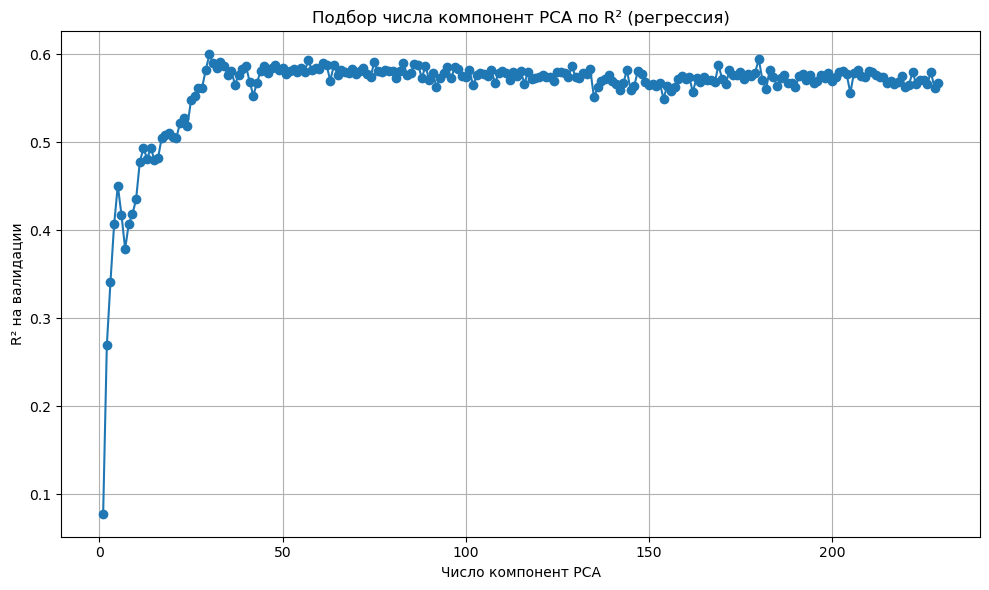

PCA преобразовал данные с 229 до 30 признаков.
Запуск 6-fold кросс-валидации на PCA-признаках...
Fold 1 R²: 0.5845
Fold 2 R²: 0.3892
Fold 3 R²: 0.4975
Fold 4 R²: 0.3700
Fold 5 R²: 0.5423
Fold 6 R²: 0.5500

Результаты кросс-валидации:
MAE: 0.5146 ± 0.0198
RMSE: 0.6658 ± 0.0286
R²: 0.4889 ± 0.0815

Оценка на тестовой выборке:
MAE: 0.4910
MSE: 0.3988
RMSE: 0.6315
MedAE: 0.4005
R²: 0.5997
Финальная модель с PCA обучена и сохранена в 'regression_IC50_catboost_final_model_pca.pkl'
Графики сохранены: 'pca_r2_optimization.png', 'log_IC50_catboost_pca_residuals.png', 'log_IC50_catboost_feature_importance_top30.png'


In [14]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import joblib

print("Сохраняю файлы в папку:", os.getcwd())

# --- Подготовка данных ---
df_copy = df.copy()
df_copy.columns = df_copy.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
if 'Unnamed_0' in df_copy.columns:
    df_copy.drop(columns=['Unnamed_0'], inplace=True)

# --- Добавление log_CC50 на основе готовой модели ---
print("Добавляем log_CC50 с помощью модели regression_CC50_lightgbm_final_model_df.pkl...")
cc50_model = joblib.load('regression_CC50_lightgbm_final_model_df.pkl')

df_cc50 = df.copy()
df_cc50.columns = df_cc50.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cc50.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in ['log_CC50', 'log_SI']:
    if col in df_cc50.columns:
        df_cc50.drop(columns=[col], inplace=True)

features_cc50 = cc50_model.feature_name_
for feat in features_cc50:
    if feat not in df_cc50.columns:
        df_cc50[feat] = np.nan

X_cc50 = df_cc50[features_cc50]

cc50_imputer = SimpleImputer(strategy='mean')
X_cc50_imputed = pd.DataFrame(cc50_imputer.fit_transform(X_cc50), columns=features_cc50)

df_copy['log_CC50'] = cc50_model.predict(X_cc50_imputed)
df_copy['CC50'] = 10 ** df_copy['log_CC50']
print("Признак CC50 добавлен в df_copy на основе log_CC50.")

# --- Разделение X и y ---
X = df_copy.drop(columns=['log_IC50'])
y = df_copy['log_IC50']

# Импутация и масштабирование
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Параметры модели
catboost_params = {
    'bagging_temperature': 0.13,
    'depth': 4,
    'iterations': 626,
    'l2_leaf_reg': 4.2,
    'learning_rate': 0.04,
    'verbose': 0,
    'random_state': 42
}

# --- Перебор количества компонент PCA от максимума к 1 ---
print("Подбор количества компонент PCA по метрике R2 (регрессия)...")
X_array = X_scaled.values
max_components = X_array.shape[1]

r2_scores = []

for n_comp in range(max_components, 0, -1):
    pca = PCA(n_components=n_comp, random_state=42)
    X_pca_temp = pca.fit_transform(X_array)
    
    # Разделяем на train/val для оценки R2
    X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
        X_pca_temp, y, test_size=0.2, random_state=42
    )
    
    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train_pca, y_train_pca)
    
    y_pred_val = model.predict(X_val_pca)
    r2 = r2_score(y_val_pca, y_pred_val)
    r2_scores.append((n_comp, r2))

best_n_pca, best_r2 = max(r2_scores, key=lambda x: x[1])
print(f"Лучшее число компонент PCA: {best_n_pca} с R² = {best_r2:.4f}")

# --- График зависимости R² от числа компонент ---
components, scores = zip(*r2_scores)
plt.figure(figsize=(10, 6))
plt.plot(components, scores, marker='o')
plt.xlabel('Число компонент PCA')
plt.ylabel('R² на валидации')
plt.title('Подбор числа компонент PCA по R² (регрессия)')
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_r2_optimization.png')
plt.show()

# --- Финальное преобразование данных с оптимальным числом компонент ---
pca_final = PCA(n_components=best_n_pca, random_state=42)
X_pca = pd.DataFrame(pca_final.fit_transform(X_array), columns=[f'PC{i+1}' for i in range(best_n_pca)], index=X.index)
print(f"PCA преобразовал данные с {X_scaled.shape[1]} до {X_pca.shape[1]} признаков.")

# --- Кросс-валидация на PCA-признаках ---
kf = KFold(n_splits=6, shuffle=True, random_state=42)

mae_list, mse_list, rmse_list, medae_list, r2_list = [], [], [], [], []

print("Запуск 6-fold кросс-валидации на PCA-признаках...")

for fold, (train_index, val_index) in enumerate(kf.split(X_pca), 1):
    X_train_cv, X_val_cv = X_pca.iloc[train_index], X_pca.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostRegressor(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv, verbose=0)

    y_pred_cv = model_cv.predict(X_val_cv)

    mae_list.append(mean_absolute_error(y_val_cv, y_pred_cv))
    mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_list.append(np.sqrt(mse_list[-1]))
    medae_list.append(median_absolute_error(y_val_cv, y_pred_cv))
    r2_list.append(r2_score(y_val_cv, y_pred_cv))

    print(f"Fold {fold} R²: {r2_list[-1]:.4f}")

print("\nРезультаты кросс-валидации:")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# --- Обучение и оценка на тестовой выборке ---
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y,
    test_size=0.2,
    random_state=42
)

cat_model_eval = CatBoostRegressor(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nОценка на тестовой выборке:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"R²: {r2:.4f}")

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки (Истинные - Предсказанные)')
plt.title(f'Остатки log(IC50) - CatBoost с PCA (R² на тесте = {r2:.4f})')
plt.tight_layout()
plt.savefig("log_IC50_catboost_pca_residuals.png")
plt.close()

# Важности признаков (уже на исходных признаках, без PCA)
cat_model_final = CatBoostRegressor(**catboost_params)
cat_model_final.fit(X_scaled, y)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("log(IC50): Топ 30 важных признаков - CatBoost Final Model")
plt.tight_layout()
plt.savefig("log_IC50_catboost_feature_importance_top30.png")
plt.close()

# Сохраняем финальную модель (на PCA-признаках)
cat_model_final_pca = CatBoostRegressor(**catboost_params)
cat_model_final_pca.fit(X_pca, y)

joblib.dump(cat_model_final_pca, 'regression_IC50_catboost_final_model_pca.pkl')
print("Финальная модель с PCA обучена и сохранена в 'regression_IC50_catboost_final_model_pca.pkl'")
print("Графики сохранены: 'pca_r2_optimization.png', 'log_IC50_catboost_pca_residuals.png', 'log_IC50_catboost_feature_importance_top30.png'")


- Проведём обучение и оценку отдельно для MLPRegression-модели

In [90]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Настройки модели ===
mlp = MLPRegressor(
    hidden_layer_sizes=(1024, 512, 256, 128, 64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.0005,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.0003,
    max_iter=3000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=40,
    random_state=42,
    verbose=False
)

# === Пути к датасетам ===
datasets = {
    "df.csv": "df.csv",
    "df_bin.csv": "df_bin.csv",
    "df_cut.csv": "df_cut.csv",
    "df_cut_bin.csv": "df_cut_bin.csv"
}

# === Целевая переменная ===
target = "log_IC50"

# === Результаты по каждому датасету ===
results = []

# tqdm для отображения прогресса
for name in tqdm(datasets, desc="Обработка датасетов"):
    path = datasets[name]
    tqdm.write(f"\n📂 Загружаем {name}")
    df = pd.read_csv(path)

    if target not in df.columns:
        tqdm.write(f"⚠️ Целевая переменная '{target}' не найдена в {name}, пропускаем.")
        continue

    # Удалим признаки, содержащие утечку
    leak_keywords = ['IC50', 'CC50', 'SI']
    leak_cols = [col for col in df.columns if any(key.lower() in col.lower() for key in leak_keywords)]
    leak_cols = list(set(leak_cols) - set([target]))  # Не удаляем целевую переменную

    if leak_cols:
        tqdm.write(f"🧹 Удаляем признаки с утечкой: {', '.join(leak_cols)}")

    # Отделяем признаки и целевую переменную
    X = df.drop(columns=[target] + leak_cols)
    y = df[target]

    # Очистка и препроцессинг
    tqdm.write("⚙️ Препроцессинг...")
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Обучение модели
    tqdm.write(" Обучаем модель...")
    model = MLPRegressor(**mlp.get_params())
    model.fit(X_train, y_train)
    tqdm.write(f" Обучение завершено. Итераций: {model.n_iter_}")

    # Предсказания и метрики
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Кросс-валидация
    tqdm.write(" Кросс-валидация...")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2', n_jobs=-1)

    # Сохраняем метрики
    results.append({
        "Dataset": name,
        "Test MAE": mae,
        "Test RMSE": rmse,
        "Test R²": r2,
        "CV R² Mean": cv_scores.mean(),
        "CV R² Std": cv_scores.std()
    })

    tqdm.write(f" {name} готово: R² = {r2:.4f}, MAE = {mae:.4f}\n")

# === Вывод таблицы результатов ===
results_df = pd.DataFrame(results)
print("\n === Сравнение результатов по датасетам ===", flush=True)
print(results_df.to_string(index=False, float_format="%.4f"), flush=True)


Обработка датасетов:   0%|          | 0/4 [00:00<?, ?it/s]


📂 Загружаем df.csv
🧹 Удаляем признаки с утечкой: FpDensityMorgan3, log_SI, FpDensityMorgan1, log_CC50, SI, CC50, mM, FpDensityMorgan2, IC50, mM
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:   0%|          | 0/4 [00:48<?, ?it/s]

 Обучение завершено. Итераций: 46
 Кросс-валидация...


Обработка датасетов:  25%|██▌       | 1/4 [04:14<12:42, 254.20s/it]

 df.csv готово: R² = 0.4479, MAE = 0.5744


📂 Загружаем df_bin.csv
🧹 Удаляем признаки с утечкой: FpDensityMorgan3, log_SI, FpDensityMorgan1, log_CC50, SI, CC50, mM, FpDensityMorgan2, IC50, mM
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:  25%|██▌       | 1/4 [05:02<12:42, 254.20s/it]

 Обучение завершено. Итераций: 46
 Кросс-валидация...


Обработка датасетов:  50%|█████     | 2/4 [08:26<08:26, 253.02s/it]

 df_bin.csv готово: R² = 0.4073, MAE = 0.5860


📂 Загружаем df_cut.csv
🧹 Удаляем признаки с утечкой: log_SI, FpDensityMorgan1, log_CC50, SI, CC50, mM, IC50, mM
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:  50%|█████     | 2/4 [09:17<08:26, 253.02s/it]

 Обучение завершено. Итераций: 51
 Кросс-валидация...


Обработка датасетов:  75%|███████▌  | 3/4 [12:30<04:08, 248.81s/it]

 df_cut.csv готово: R² = 0.3813, MAE = 0.5842


📂 Загружаем df_cut_bin.csv
🧹 Удаляем признаки с утечкой: log_SI, FpDensityMorgan1, log_CC50, SI, CC50, mM, IC50, mM
⚙️ Препроцессинг...
 Обучаем модель...


Обработка датасетов:  75%|███████▌  | 3/4 [13:13<04:08, 248.81s/it]

 Обучение завершено. Итераций: 50
 Кросс-валидация...


Обработка датасетов: 100%|██████████| 4/4 [16:02<00:00, 240.59s/it]

 df_cut_bin.csv готово: R² = 0.4470, MAE = 0.5595


 === Сравнение результатов по датасетам ===
       Dataset  Test MAE  Test RMSE  Test R²  CV R² Mean  CV R² Std
        df.csv    0.5744     0.7416   0.4479      0.4146     0.0819
    df_bin.csv    0.5860     0.7346   0.4073      0.4145     0.0722
    df_cut.csv    0.5842     0.7851   0.3813      0.3508     0.1114
df_cut_bin.csv    0.5595     0.7096   0.4470      0.4188     0.0654
